In [2]:
import os.path

import numpy as np
import pandas as pd

In [3]:
classesDict = {
    "T1":0,
    "T1_c":1,
    "T2":2,
    "T2-FLAIR":3,
    "PD":4,
    "SWI":5,
    "GRE":6,
    "T2*":7,
    "DWI":8,
    "ADC":9,
    "BOLD":10,
    "angio":11,
    "PWI":12,
    "ASL":13,
    "DTI":14,
    "Other":15
}
orig_label_list = list(classesDict.keys())

In [4]:
train_labels_path = 'combinedDfs/CombinedTrainingFrame_A2_A3_O3_egd_rss_hb_pruned.txt'
test_labels_path = 'combinedDfs/CombinedTestingFrame_A2_A3_O3_egd_rss_hb_pruned.txt'

In [5]:
train_labels = pd.read_csv(train_labels_path,names=['ID','label','extra'],sep='\t', dtype={'ID':str,'label':int,'extra':int})
test_labels = pd.read_csv(test_labels_path,names=['ID','label','extra'],sep='\t', dtype={'ID':str,'label':int,'extra':int})

In [6]:
Label_name_list = list(classesDict.keys())

In [7]:
Labels = pd.concat((train_labels, test_labels), axis=0)
Labels

,ID,label,extra
0,/trinity/home/r098375/DDS/data/ADNI/ADNI3/trai...,3,0
1,/trinity/home/r098375/DDS/data/ADNI/ADNI3/trai...,7,0
2,/trinity/home/r098375/DDS/data/ADNI/ADNI3/trai...,0,0
3,/trinity/home/r098375/DDS/data/ADNI/ADNI3/trai...,3,0
4,/trinity/home/r098375/DDS/data/ADNI/ADNI3/trai...,15,0
...,...,...,...
63715,/data/scratch/r098375/data/HeartBrain/NIFTI_SL...,12,0
63716,/data/scratch/r098375/data/HeartBrain/NIFTI_SL...,12,0
63717,/data/scratch/r098375/data/HeartBrain/NIFTI_SL...,12,0
63718,/data/scratch/r098375/data/HeartBrain/NIFTI_SL...,12,0


In [8]:
all_binnings_dict = {
    'DDS_binning': {
        'non_DDS': ['SWI', 'GRE', 'T2*', 'ADC', 'BOLD', 'angio', 'ASL', 'DTI']
    },
    'alternative_binning': {
        'diffusion': ['DWI', 'ADC', 'DTI'],
        'perfusion': ['BOLD', 'ASL', 'angio', 'PWI'],
        'suscept': ['SWI', 'GRE', 'T2*']
    }
}


def createBinning(original_labelmap, binningDict):
    orignal_labelmap_copy = original_labelmap.copy()
    new_labelmap = {}
    transfer_array = np.zeros(len(original_labelmap))
    class_counter = 0
    for bin_name, bin_items in binningDict.items():
        new_labelmap[bin_name] = class_counter
        for item in list(bin_items):
            transfer_array[original_labelmap[item]] = class_counter
            orignal_labelmap_copy.pop(item)
        class_counter += 1
    for name, item in orignal_labelmap_copy.items():
        new_labelmap[name] = class_counter
        transfer_array[item] = class_counter
        class_counter += 1
    unchangedLabels = orignal_labelmap_copy
    return new_labelmap, transfer_array, class_counter, unchangedLabels


new_labelmap, transfer_array, class_counter, unchangedLabels = (createBinning
                                                                (classesDict,
                                        all_binnings_dict['alternative_binning'])
                                                                )
alt_label_list = list(new_labelmap.keys())

def apply_binning_to_df(original_df, transfer_array, suffix=""):
    df = original_df.copy()
    suffix = '_' + suffix
    df[f'label{suffix}'] = df['label'].apply(lambda x: int(transfer_array[x]))
    return df

In [11]:
new_labelmap

{'diffusion': 0,
 'perfusion': 1,
 'suscept': 2,
 'T1': 3,
 'T1_c': 4,
 'T2': 5,
 'T2-FLAIR': 6,
 'PD': 7,
 'Other': 8}

In [12]:
binned_df = apply_binning_to_df(Labels, transfer_array, suffix='alt')
binned_df['orig_string_label'] = binned_df['label'].apply(lambda x: orig_label_list[x])
binned_df['alt_string_label'] = binned_df['label_alt'].apply(lambda x: alt_label_list[x])
binned_df.head()

,ID,label,extra,label_alt,orig_string_label,alt_string_label
0,/trinity/home/r098375/DDS/data/ADNI/ADNI3/trai...,3,0,6,T2-FLAIR,T2-FLAIR
1,/trinity/home/r098375/DDS/data/ADNI/ADNI3/trai...,7,0,2,T2*,suscept
2,/trinity/home/r098375/DDS/data/ADNI/ADNI3/trai...,0,0,3,T1,T1
3,/trinity/home/r098375/DDS/data/ADNI/ADNI3/trai...,3,0,6,T2-FLAIR,T2-FLAIR
4,/trinity/home/r098375/DDS/data/ADNI/ADNI3/trai...,15,0,8,Other,Other


In [13]:
FullLabelFrame = binned_df.copy()

In [15]:
FullLabelFrame.groupby('alt_string_label')['orig_string_label'].value_counts()/15

alt_string_label  orig_string_label
Other             Other                11955.0
PD                PD                     256.0
T1                T1                    5242.0
T1_c              T1_c                   385.0
T2                T2                    2939.0
T2-FLAIR          T2-FLAIR              2770.0
diffusion         DWI                   2462.0
                  DTI                    161.0
                  ADC                    113.0
perfusion         BOLD                  3034.0
                  ASL                   1631.0
                  PWI                   1446.0
                  angio                  557.0
suscept           T2*                   5392.0
                  SWI                   1930.0
                  GRE                    437.0
Name: count, dtype: float64

In [17]:
print((FullLabelFrame.groupby('orig_string_label')['alt_string_label'].value_counts()/15).to_latex())

\begin{tabular}{llr}
\toprule
 &  & count \\
orig_string_label & alt_string_label &  \\
\midrule
ADC & diffusion & 113.000000 \\
\cline{1-3}
ASL & perfusion & 1631.000000 \\
\cline{1-3}
BOLD & perfusion & 3034.000000 \\
\cline{1-3}
DTI & diffusion & 161.000000 \\
\cline{1-3}
DWI & diffusion & 2462.000000 \\
\cline{1-3}
GRE & suscept & 437.000000 \\
\cline{1-3}
Other & Other & 11955.000000 \\
\cline{1-3}
PD & PD & 256.000000 \\
\cline{1-3}
PWI & perfusion & 1446.000000 \\
\cline{1-3}
SWI & suscept & 1930.000000 \\
\cline{1-3}
T1 & T1 & 5242.000000 \\
\cline{1-3}
T1_c & T1_c & 385.000000 \\
\cline{1-3}
T2 & T2 & 2939.000000 \\
\cline{1-3}
T2* & suscept & 5392.000000 \\
\cline{1-3}
T2-FLAIR & T2-FLAIR & 2770.000000 \\
\cline{1-3}
angio & perfusion & 557.000000 \\
\cline{1-3}
\bottomrule
\end{tabular}


In [25]:
vc = pd.DataFrame(FullLabelFrame.groupby('alt_string_label')['orig_string_label'].value_counts())

In [27]:
vc

count
alt_string_label orig_string_label        
Other            Other              179325
PD               PD                   3840
T1               T1                  78630
T1_c             T1_c                 5775
T2               T2                  44085
T2-FLAIR         T2-FLAIR            41550
diffusion        DWI                 36930
                 DTI                  2415
                 ADC                  1695
perfusion        BOLD                45510
                 ASL                 24465
                 PWI                 21690
                 angio                8355
suscept          T2*                 80880
                 SWI                 28950
                 GRE                  6555

In [28]:
first_level_labels = []
second_level_labels = []
first_level_counts = []
second_level_counts = []
for idx in vc.index:
    firstLevel = idx[0]
    secondLevel = idx[1]
    count = vc.loc[idx,'count']
    if firstLevel not in first_level_labels:
        first_level_labels.append(firstLevel)
        second_level_labels.append(secondLevel)
        first_level_counts.append(count)
        second_level_counts.append(count)
    else:
        second_level_counts.append(count)
        second_level_labels.append(secondLevel)
        first_level_counts[-1] += count
unique_second_level = list(set(second_level_labels))

In [35]:
second_level_colors = [unique_second_level.index(x) for x in second_level_labels]

In [36]:
second_level_colors

[13, 2, 4, 7, 10, 6, 3, 1, 14, 11, 15, 9, 12, 0, 5, 8]

In [54]:
import matplotlib.pyplot as plt


size = 0.3

cmap_outer = plt.colormaps["tab10"]
cmap_20b = plt.colormaps['tab20b']
cmap_20c = plt.colormaps['tab20c']
outer_colors = cmap_outer(np.arange(len(first_level_labels)))
inner_colors = np.zeros((16,4))
inner_colors[0:6,:] = cmap_outer([0,1,2,3,4,5])
inner_colors[6:9] = cmap_20b([17,18,19])
inner_colors[9:13] = cmap_20c([16,17,18,19])
inner_colors[13:] = cmap_20b([8,9,10])

In [55]:
outer_colors

array([[0.12156863, 0.46666667, 0.70588235, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.54901961, 0.3372549 , 0.29411765, 1.        ],
       [0.89019608, 0.46666667, 0.76078431, 1.        ],
       [0.49803922, 0.49803922, 0.49803922, 1.        ],
       [0.7372549 , 0.74117647, 0.13333333, 1.        ]])

In [56]:
inner_colors

array([[0.12156863, 0.46666667, 0.70588235, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.54901961, 0.3372549 , 0.29411765, 1.        ],
       [0.64705882, 0.31764706, 0.58039216, 1.        ],
       [0.80784314, 0.42745098, 0.74117647, 1.        ],
       [0.87058824, 0.61960784, 0.83921569, 1.        ],
       [0.38823529, 0.38823529, 0.38823529, 1.        ],
       [0.58823529, 0.58823529, 0.58823529, 1.        ],
       [0.74117647, 0.74117647, 0.74117647, 1.        ],
       [0.85098039, 0.85098039, 0.85098039, 1.        ],
       [0.54901961, 0.42745098, 0.19215686, 1.        ],
       [0.74117647, 0.61960784, 0.22352941, 1.        ],
       [0.90588235, 0.72941176, 0.32156863, 1.        ]])

In [57]:
first_level_counts

[179325, 3840, 78630, 5775, 44085, 41550, 41040, 100020, 116385]

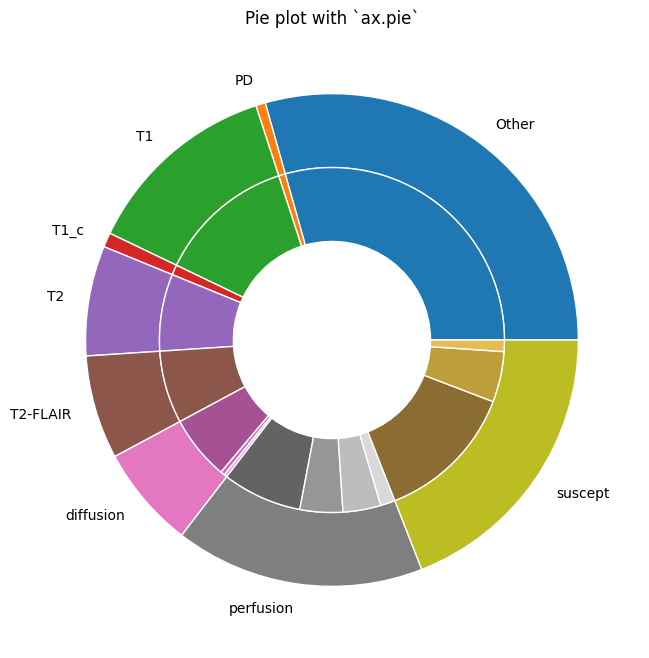

In [58]:
fig, ax = plt.subplots(figsize=(8,8))
ax.pie(first_level_counts, radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels=first_level_labels)

ax.pie(second_level_counts, radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()

In [19]:
labels = FullLabelFrame['orig_string_label'].unique()

In [20]:
alt_string_labels = FullLabelFrame[FullLabelFrame['orig_string_label']==labels[0]]['alt_string_label'].unique()

In [21]:
FullLabelFrame['center_slide'] = FullLabelFrame['ID'].apply(lambda x: '__s12' in x)

In [22]:
VisualizeFrame = FullLabelFrame[FullLabelFrame['center_slide']]

In [23]:
# create a frame that contains labels for some visualizations
from sklearn.model_selection import train_test_split
visualize_frame = pd.DataFrame()
for label in labels:
    temp1 = VisualizeFrame[VisualizeFrame['orig_string_label']==label]
    alt_string_labels = temp1['alt_string_label'].unique()
    for alt_string_label in alt_string_labels:
        df = temp1[temp1['alt_string_label']==alt_string_label]
        try:
            visualize, _ = train_test_split(df, train_size=2, shuffle=True, random_state=42)
        except ValueError:
            visualize = df
        visualize_frame = pd.concat([visualize_frame,visualize], axis=0)

In [24]:
visualize_frame

,ID,label,extra,dataset,string_label,center_slide
170362,/trinity/home/r098375/DDS/data/ADNI/ADNI3/trai...,3,0,ADNI3,T2-FLAIR,True
130877,/trinity/home/r098375/DDS/data/ADNI/ADNI3/trai...,3,0,ADNI3,T2-FLAIR,True
391847,/trinity/home/r098375/DDS/data/OASIS/OASIS3/tr...,3,0,OASIS3,T2-FLAIR,True
259111,/trinity/home/r098375/DDS/data/OASIS/OASIS3/tr...,3,0,OASIS3,T2-FLAIR,True
204631,/trinity/home/r098375/DDS/data/ADNI/ADNI3/trai...,7,0,ADNI3,T2*,True
...,...,...,...,...,...,...
266550,/trinity/home/r098375/DDS/data/OASIS/OASIS3/tr...,11,0,OASIS3,angio,True
505981,/trinity/home/r098375/DDS/data/egd/NIFTI_SLICE...,9,0,egd,ADC,True
58487,/trinity/home/r098375/DDS/data/egd/NIFTI_SLICE...,9,0,egd,ADC,True
56750,/trinity/home/r098375/DDS/data/egd/NIFTI_SLICE...,1,0,egd,T1_c,True


In [25]:
# visualize_frame.to_csv('visualizeFrame.csv', index=False)